### Training model

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from app_runner import Wrappers

Using TensorFlow backend


In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)


In [3]:
# x_train as pandas.DataFrame, y_train as pandas.Series
x_train = pd.read_csv(train_file_path)
print(type(x_train))  # pandas.DataFrame
y_train = x_train.pop("survived")
print(type(y_train))  # pandas.Series

# # You can also use pandas.DataFrame for y_train.
# y_train = pd.DataFrame(y_train)
# print(type(y_train))  # pandas.DataFrame

# Preparing testing data.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [4]:
x_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [5]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


In [6]:
feature_type = {}
for feature in x_train.columns:
    if x_train[feature].dtype == 'int64' or x_train[feature].dtype == 'float64':
        feature_type[feature] = 'numerical'
    else:
        feature_type[feature] = 'categorical'

feature_type

{'sex': 'categorical',
 'age': 'numerical',
 'n_siblings_spouses': 'numerical',
 'parch': 'numerical',
 'fare': 'numerical',
 'class': 'categorical',
 'deck': 'categorical',
 'embark_town': 'categorical',
 'alone': 'categorical'}

In [7]:
cls_obj = Wrappers()

App ready and running...


In [8]:
cls_obj.StructuredDataClassifier(overwrite=True, max_trials=2, column_names = list(x_train.columns), column_types = feature_type, num_classes = 2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
history = cls_obj.sdc_fit(
    x = train_file_path,
    y = "survived",
    epochs=10 , 
    callbacks=[tensorboard_callback]
)

Trial 2 Complete [00h 00m 09s]
val_accuracy: 0.8695651888847351

Best val_accuracy So Far: 0.8695651888847351
Total elapsed time: 00h 00m 19s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
20/20 [==============================] - 1s 5ms/step - loss: 0.7222 - accuracy: 0.4657
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6383 - accuracy: 0.6140
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.5845 - accuracy: 0.6762
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.5423 - accuracy: 0.7544
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.5071 - accuracy: 0.7943
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.4791 - accuracy: 0.8198
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.4577 - accuracy: 0.8262
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.4421 - accuracy: 0.8325
Epoch 9/10
20/20 [==================

In [17]:
predicted_y = cls_obj.sdc_predict(x_test.iloc[0:10,:])
print(predicted_y)
# Evaluate the best model with testing data.
print(cls_obj.sdc_evaluate(test_file_path, "survived"))

NameError: name 'x_test' is not defined

In [29]:
model = cls_obj.clk.export_model()

In [10]:
model.summary()

NameError: name 'model' is not defined

#### Read and prepreocess Test File 

In [24]:
x_test = pd.read_csv(test_file_path)
y_test_og = x_test["survived"]
x_test = x_test.drop(["survived"], axis=1)

input_data = np.array(x_test.iloc[6,:])
explain_data = np.array(x_test.iloc[6,:])

input_data = input_data.tolist()
input_data

['female', 8.0, 3, 1, 21.075, 'Third', 'unknown', 'Southampton', 'n']

#### Disect the model

In [31]:
from tensorflow.keras.models import Model


In [32]:
# Splitting the model into two parts 
# 1. Preprocessing model for calculating the preprocessed features
preprocessing_model = Model(inputs=model.input, outputs=model.layers[2].output)  

output = preprocessing_model.predict(input_data)
output

1/1 [==============================] - 0s 150ms/step


array([[ 1.3745551 , -1.7302506 ,  3.4378278 ,  0.80190986, -0.24398494,
        -0.82992667, -0.45484465, -0.57665044,  1.2078174 ]],
      dtype=float32)

In [27]:
for layer in preprocessing_model.layers:
    print(layer)
    if hasattr(layer, 'weights'):
        weights = layer.get_weights()  # Returns a list of numpy arrays
        print(f"Weights of {layer.name}:")
        for weight_array in weights:
            k = weight_array
            print(weight_array.shape)
            print(weight_array)

Weights of input_1:
Weights of multi_category_encoding:
(2,)
[b'male' b'female']
(3,)
[b'Third' b'First' b'Second']
(8,)
[b'unknown' b'C' b'B' b'E' b'D' b'A' b'F' b'G']
(4,)
[b'Southampton' b'Cherbourg' b'Queenstown' b'unknown']
(2,)
[b'y' b'n']
Weights of normalization:
(9,)
[ 1.3460923  29.631308    0.5454546   0.37958536 34.3854      1.6586922
  1.6267942   1.3700157   1.4066987 ]
(9,)
[2.2631252e-01 1.5629588e+02 1.3228940e+00 6.2784487e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
()
627


In [33]:
for layer in preprocessing_model.layers:
    print(layer)
    if hasattr(layer, 'weights'):
        weights = layer.get_weights()  # Returns a list of numpy arrays
        print(f"Weights of {layer.name}:")
        for weight_array in weights:
            k = weight_array
            print(weight_array.shape)
            print(weight_array)

Weights of input_1:
Weights of multi_category_encoding:
(2,)
[b'male' b'female']
(7,)
[b'0' b'1' b'2' b'4' b'3' b'8' b'5']
(6,)
[b'0' b'1' b'2' b'5' b'4' b'3']
(3,)
[b'Third' b'First' b'Second']
(8,)
[b'unknown' b'C' b'B' b'E' b'D' b'A' b'F' b'G']
(4,)
[b'Southampton' b'Cherbourg' b'Queenstown' b'unknown']
(2,)
[b'y' b'n']
Weights of normalization:
(9,)
[ 1.3460923 29.631308   1.5199361  1.3763956 34.3854     1.6586922
  1.6267942  1.3700157  1.4066987]
(9,)
[2.2631252e-01 1.5629588e+02 1.0247223e+00 6.0473800e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
()
627


In [12]:
import autokeras as ak
preprocessing_block = ak.StructuredDataBlock(categorical_encoding=True, normalize=None, seed=None)



In [19]:
    # The user specifies the high-level architecture.
import autokeras as ak
image_input = ak.ImageInput()
image_output = ak.ImageBlock()(image_input)
text_input = ak.TextInput()
text_output = ak.TextBlock()(text_input)
output = ak.Merge()([image_output, text_output])
classification_output = ak.ClassificationHead()(output)
regression_output = ak.RegressionHead()(output)
auto_model  = ak.AutoModel(
    inputs=[image_input, text_input],
    outputs=[classification_output, regression_output], 
    overwrite=True
)


In [ ]:
# 2. Actual Dense model
dense_model = Model(inputs=model.layers[3].input, outputs=model.output) 

final_output = dense_model.predict(output)
final_output

1/1 [==============================] - 0s 121ms/step


array([[0.00067152]], dtype=float32)

In [ ]:
#Predictions from the model
predictions = cls_obj.sdc_predict(explain_data)
pred = [int(i[0]) for i in predictions]
pred

1/1 [==============================] - 0s 13ms/step


[0]

In [ ]:
#PLotting helper function
def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """

    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    print(feat_imp, feat_names)
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    ax.set_title(f'What does each features contribute to the model prediction?', fontsize=18)
    return ax, fig

[[-0.13396629 -0.10287538  0.47828072  0.0148715   0.05366303  0.21312969
   0.00727013  0.02992694 -0.04356381]]
[-0.13396629 -0.10287538 -0.04356381  0.00727013  0.0148715   0.02992694
  0.05366303  0.21312969  0.47828072] Index(['sex', 'age', 'alone', 'deck', 'parch', 'embark_town', 'fare', 'class',
       'n_siblings_spouses'],
      dtype='object')


(<Axes: title={'center': 'What does each feature contribute to the model prediction?'}, xlabel='Feature effects for class "did_not_survive"'>,
 <Figure size 1000x500 with 1 Axes>)

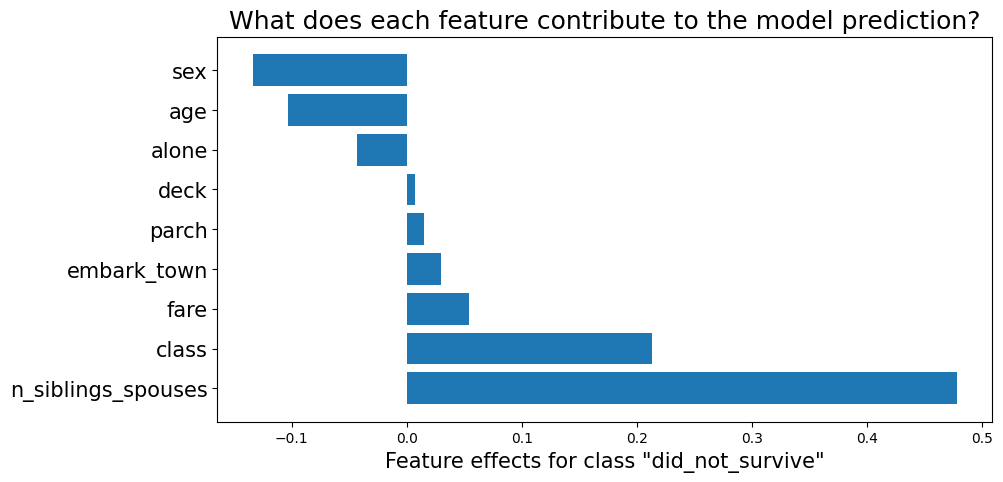

In [ ]:
#Integrated gradients- What/How much does each feature contribute to the model prediction?
#INFO: It works on instacne basis
# Give integrated gradients for different instances 
from alibi.explainers import IntegratedGradients
ig  = IntegratedGradients(dense_model, n_steps=100)

explanation = ig.explain(output, target=pred)
attributions = explanation.data['attributions'][0]
# Print or analyze the attribution scores as needed
print(attributions)

pred_class = '"did_not_survive"' if pred[0] == 0 else '"survived"'
plot_importance(attributions, x_test.columns, pred_class)

In [ ]:
X_train = pd.read_csv(train_file_path)
Y_train = X_train["survived"]
X_train = X_train.drop(["survived"], axis=1)

In [ ]:
X_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [ ]:
X_train_list = X_train.to_numpy().tolist()


In [ ]:
model.predict(X_train_list)[0]

20/20 [==============================] - 0s 3ms/step


array([0.266851], dtype=float32)

In [ ]:
pred(X_train_list)

20/20 [==============================] - 0s 2ms/step


array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [ ]:
X_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [ ]:
int_cols = []
cat_cols = []
for col_name in X_train.columns:
    p = X_train[col_name].unique()
    if len(p) <10:
        cat_cols.append(col_name)
    else:
        int_cols.append(col_name)


In [ ]:
cat_cols

['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

In [ ]:
int_cols

['age', 'fare']

In [ ]:
model.predict(X_train.to_numpy().tolist())

20/20 [==============================] - 0s 3ms/step


array([[2.66851008e-01],
       [9.99869227e-01],
       [4.64619219e-01],
       [9.96719301e-01],
       [1.46459401e-01],
       [1.50249733e-04],
       [5.08011997e-01],
       [9.99990523e-01],
       [5.08011997e-01],
       [2.37389803e-01],
       [1.85185727e-02],
       [5.08011997e-01],
       [3.64329740e-02],
       [2.13823944e-01],
       [5.08011997e-01],
       [5.08011997e-01],
       [2.64362097e-01],
       [3.77005905e-01],
       [9.75371450e-02],
       [2.35052362e-01],
       [8.27448606e-01],
       [5.08011997e-01],
       [2.89339900e-01],
       [3.50753754e-01],
       [9.99999583e-01],
       [5.08011997e-01],
       [5.08011997e-01],
       [4.10373122e-01],
       [2.54956990e-01],
       [2.35046372e-01],
       [5.08011997e-01],
       [3.11439514e-01],
       [9.99588490e-01],
       [2.34089613e-01],
       [9.99999583e-01],
       [2.89352834e-01],
       [8.05510283e-02],
       [5.49985887e-03],
       [5.08011997e-01],
       [4.27560555e-03],


9/9 [==============================] - 0s 2ms/step


array([[<Axes: xlabel='fare', ylabel='ALE'>]], dtype=object)

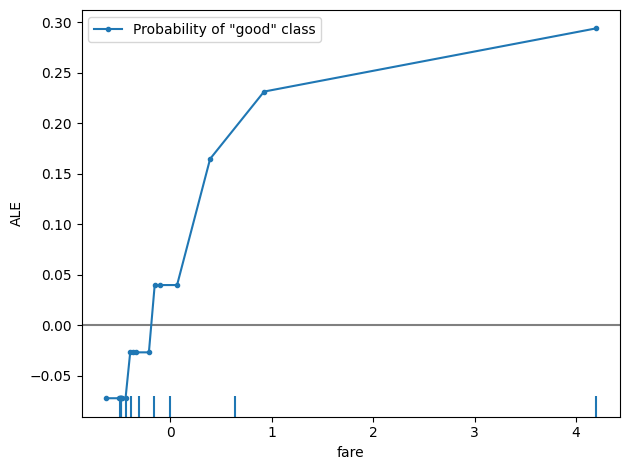

In [ ]:
#Accumulated Local Effects- How does model prediction vary with respect to features of interest?
#INFO: It works on numerical featues
# Gives ALE for different numerical features
# ALE should be wrt to a class good/bad 
#TODO: change the pred() funtion to give output wrt to a specific
from alibi.explainers import ALE, plot_ale

def pred(x):
    predictions = dense_model.predict(x)
    final_predictions = (predictions > 0.5).astype(int)
    return final_predictions

# Model is a binary classifier so we only take the first model output corresponding to "good" class probability.
output = preprocessing_model.predict(x_test.to_numpy().tolist())
ale = ALE(pred, feature_names=X_train.columns)
exp = ale.explain(output)

plot_ale(exp, features=['fare'], line_kw={'label': 'Probability of "good" class'})

['sex',
 'age',
 'n_siblings_spouses',
 'parch',
 'fare',
 'class',
 'deck',
 'embark_town',
 'alone']

In [ ]:
anchor_pred(X_train.iloc[1,:].to_numpy().tolist())

1/1 [==============================] - 0s 37ms/step


array([[1]])

In [ ]:
X_train.iloc[1,:].to_numpy().tolist()

['female', 38.0, 1, 0, 71.2833, 'First', 'C', 'Cherbourg', 'n']

In [ ]:
list(X_train.columns)

['sex',
 'age',
 'n_siblings_spouses',
 'parch',
 'fare',
 'class',
 'deck',
 'embark_town',
 'alone']

In [ ]:
def anchor_pred(x):
    print(x)
    predictions = dense_model.predict(x)
    final_predictions = (predictions > 0.5).astype(int)
    return final_predictions

In [ ]:
from alibi.explainers import AnchorTabular

predict_fn = anchor_pred
explainer = AnchorTabular(predict_fn, list(X_train.columns))
explainer.fit(output)

# x is the instance to explain
result = explainer.explain(output)

print('Anchor =', result.data['anchor'])
print('Coverage = ', result.data['coverage'])

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 45ms/step
[[-0.7275079   0.42943236 -0.5136258  -0.48401728 -0.48273844 -0.82992667
  -0.45484465 -0.57665044 -0.8279398 ]]
1/1 [==============================] - 0s 37ms/step
[[ 1.3745551e+00  7.4938542e-01  4.7423756e-01  8.0190986e-01
   1.4022372e+00  4.3003452e-01  2.7082357e-01  9.8179793e-01
   1.2078174e+00]
 [ 1.3745551e+00  7.4938542e-01  4.7423756e-01 -4.8401728e-01
   3.9437130e-01  4.3003452e-01  1.7221600e+00 -5.7665044e-01
   1.2078174e+00]
 [-7.2750789e-01 -7.7039152e-01 -5.1362580e-01 -4.8401728e-01
  -5.5674738e-01 -8.2992667e-01 -4.5484465e-01  9.8179793e-01
  -8.2793981e-01]
 [-7.2750789e-01  2.9491063e-02 -5.1362580e-01 -4.8401728e-01
  -4.5615935e-01 -8.2992667e-01 -4.5484465e-01 -5.7665044e-01
  -8.2793981e-01]
 [ 1.3745551e+00 -6.9040328e-01  4.7423756e-01 -4.8401728e-01
  -4.5020196e-01 -8.2992667e-01 -4.5484465e-01 -5.7665044e-01
   1.2078174e+00]
 [ 1.3745551e+00 -1.3048546e-01 -5.136258

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
for layer in model.layers:
    print(layer)
    if hasattr(layer, 'weights'):
        weights = layer.get_weights()  # Returns a list of numpy arrays
        print(f"Weights of {layer.name}:")
        for weight_array in weights:
            k = weight_array
            print(weight_array.shape)
            print(weight_array)

Weights of input_1:
Weights of multi_category_encoding:
(2,)
[b'male' b'female']
(7,)
[b'0' b'1' b'2' b'4' b'3' b'8' b'5']
(6,)
[b'0' b'1' b'2' b'5' b'4' b'3']
(3,)
[b'Third' b'First' b'Second']
(8,)
[b'unknown' b'C' b'B' b'E' b'D' b'A' b'F' b'G']
(4,)
[b'Southampton' b'Cherbourg' b'Queenstown' b'unknown']
(2,)
[b'y' b'n']
Weights of normalization:
(9,)
[ 1.3460923 29.631308   1.5199361  1.3763956 34.3854     1.6586922
  1.6267942  1.3700157  1.4066987]
(9,)
[2.2631252e-01 1.5629588e+02 1.0247223e+00 6.0473800e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
()
627
Weights of dense:
(9, 32)
[[ 1.0576434  -0.35929665 -1.2357174   0.47566906 -0.02816359  2.6433935
  -0.14225444 -0.33795315  1.1293479   2.089843   -0.5029013  -1.3011488
   1.4498525  -0.7511772   0.4753492   0.30278692 -0.636578    0.730574
  -0.68008864  1.0636848  -0.51590735  0.05025548 -0.28250653  1.4780889
   0.21208972  0.2892703   0.6289771   0.7288685  -0.38018528  0.4639636
   0.016160

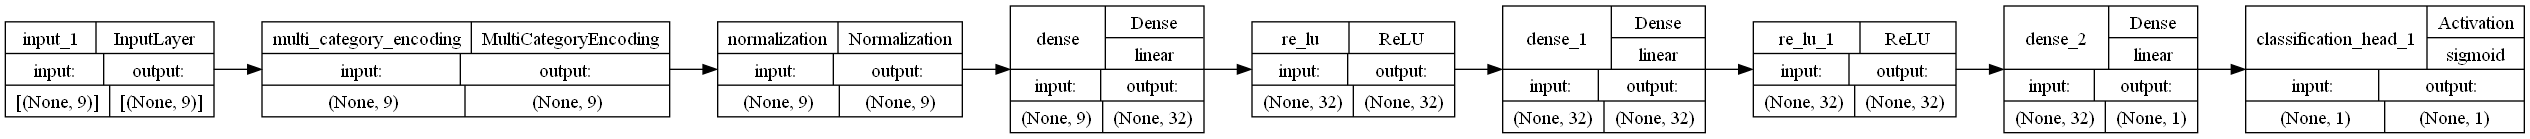

In [ ]:
from keras.utils import vis_utils
vis_utils.plot_model(model, to_file='test_model.png', show_shapes=True, show_layer_names=True,rankdir='LR', expand_nested=True, show_layer_activations=True )

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

import autokeras as ak


In [ ]:
house_dataset = fetch_california_housing()
df = pd.DataFrame(
    np.concatenate(
        (house_dataset.data, house_dataset.target.reshape(-1, 1)), axis=1
    ),
    columns=house_dataset.feature_names + ["Price"],
)
train_size = int(df.shape[0] * 0.9)
df[:train_size].to_csv("train.csv", index=False)
df[train_size:].to_csv("eval.csv", index=False)
train_file_path = "train.csv"
test_file_path = "eval.csv"


In [ ]:
# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True, max_trials=3
)  # It tries 3 different models.
# Feed the structured data regressor with training data.
reg.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "Price",
    epochs=100,
)
# Predict with the best model.
predicted_y = reg.predict(test_file_path)
# Evaluate the best model with testing data.
print(reg.evaluate(test_file_path, "Price"))


Trial 3 Complete [00h 00m 40s]
val_loss: 0.8961352705955505

Best val_loss So Far: 0.8961352705955505
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
581/581 [==============================] - 2s 2ms/step - loss: 4.9231 - mean_squared_error: 4.9231
Epoch 2/100
581/581 [==============================] - 2s 3ms/step - loss: 1.9850 - mean_squared_error: 1.9850
Epoch 3/100
581/581 [==============================] - 1s 2ms/step - loss: 0.9098 - mean_squared_error: 0.9098
Epoch 4/100
581/581 [==============================] - 1s 3ms/step - loss: 0.7267 - mean_squared_error: 0.7267
Epoch 5/100
581/581 [==============================] - 1s 2ms/step - loss: 0.6274 - mean_squared_error: 0.6274
Epoch 6/100
581/581 [==============================] - 1s 3ms/step - loss: 0.5718 - mean_squared_error: 0.5718
Epoch 7/100
581/581 [==============================] - 1s 2ms/step - loss: 0.5442 - mean_squared_error: 0.5442
Epoch 8/100
581/581 [==============================

INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


65/65 [==============================] - 0s 2ms/step - loss: 0.3505 - mean_squared_error: 0.3505
[0.3504956066608429, 0.3504956066608429]


In [ ]:
reg_model = reg.export_model()

In [ ]:
reg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 8)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)


(60000, 28, 28)
(60000,)
[5 0 4]


In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)


# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))


Trial 1 Complete [00h 16m 21s]
val_loss: 0.03539927676320076

Best val_loss So Far: 0.03539927676320076
Total elapsed time: 00h 16m 21s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1875/1875 [==============================] - 103s 54ms/step - loss: 0.1650 - accuracy: 0.9503
Epoch 2/10
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0755 - accuracy: 0.9767
Epoch 3/10
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0617 - accuracy: 0.9810
Epoch 4/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0538 - accuracy: 0.9829
Epoch 5/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0463 - accuracy: 0.9853
Epoch 6/10
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0396 - accuracy: 0.9868
Epoch 7/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0388 - accuracy: 0.9871
Epoch 8/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0343 - accuracy: 0.9885
Epoch 9/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0327 - accuracy: 0.9895
Epoch 10/10
1875/1875 [==============================] 

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


313/313 [==============================] - 4s 13ms/step
[['7']
 ['2']
 ['1']
 ...
 ['4']
 ['5']
 ['6']]
313/313 [==============================] - 4s 13ms/step - loss: 0.0391 - accuracy: 0.9878
[0.03907911479473114, 0.9878000020980835]


In [ ]:
# INPUT NODES
'''ImageInput
    Input
    StructuredDataInput
    TextInput'''

# Types of block
'''ConvBlock
    DenseBlock
    Embedding
    Merge
    ResNetBlock
    RNNBlock
    SpatialReduction
    TemporalReduction
    XceptionBlock
    ImageBlock
    StructuredDataBlock
    TextBlock
    ImageAugmentation
    Normalization
    TextToIntSequence
    TextToNgramVector
    CategoricalToNumerical
    ClassificationHead
    RegressionHead'''

# Utilities
'''
    image_dataset_from_directory
    text_dataset_from_directory
'''

In [ ]:
import json

# Open the JSON file for reading
with open('D:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\structured_data_classifier\\trial_0\\trial_mid1695578881179.json', 'r') as file:
    # Use json.load() to parse the JSON data
    data = json.load(file)

# Now, 'data' contains the parsed JSON data as a Python dictionary or list


In [ ]:
data

{'trial_id': '0',
 'hyperparameters': {'space': [{'class_name': 'Boolean',
    'config': {'name': 'structured_data_block_1/normalize',
     'default': False,
     'conditions': []}},
   {'class_name': 'Boolean',
    'config': {'name': 'structured_data_block_1/dense_block_1/use_batchnorm',
     'default': False,
     'conditions': []}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/num_layers',
     'default': 2,
     'conditions': [],
     'values': [1, 2, 3],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/units_0',
     'default': 32,
     'conditions': [],
     'values': [16, 32, 64, 128, 256, 512, 1024],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/dropout',
     'default': 0.0,
     'conditions': [],
     'values': [0.0, 0.25, 0.5],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name'